In [1]:
import os,sys
os.environ['KERAS_BACKEND'] = 'tensorflow'
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import tensorflow as tf
import numpy as np
from keras import backend as K
import tables
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

Using TensorFlow backend.


[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 1831112463704007972, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 15578061210
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 1093174279211123291
 physical_device_desc: "device: 0, name: Tesla V100-SXM2-16GB, pci bus id: 0000:00:04.0, compute capability: 7.0"]

In [2]:
# These directories were chosen because they write the data to local disk, which will have the fastest access time
# of our various storage options.
custom_weights_dir = os.path.expanduser("../weights-floatingpoint")
custom_weights_dir_q = os.path.expanduser("../weights-quantized")
custom_weights_dir_tl = os.path.expanduser("../weights-transferlearning-floatingpoint")
saved_model_dir = os.path.expanduser("../models")

In [3]:
import glob
from utils import normalize_and_rgb, image_with_label, count_events
datadir = "../data/"
n_train_file = 1
n_test_file = 1
n_val_file = 1

train_files = glob.glob(os.path.join(datadir, 'train_file_*'))
test_files = glob.glob(os.path.join(datadir, 'test/test_file_*'))
val_files = glob.glob(os.path.join(datadir, 'val_file_*'))
train_files = train_files[:n_train_file]
test_files = test_files[:n_test_file]
val_files = test_files[:n_val_file]

n_train_events = count_events(train_files)
n_test_events = count_events(test_files)
n_val_events = count_events(val_files)

print("n_train_events =", n_train_events)
print("n_test_events =", n_test_events)
print("n_val_events =", n_val_events)

n_train_events = 50000
n_test_events = 50000
n_val_events = 50000


In [4]:
from utils import preprocess_images, construct_model

In [5]:
from utils import chunks, train_model, test_model

In [6]:
def create_sprite_image(images):
    """Returns a sprite image consisting of images passed as argument. Images should be count x width x height"""
    if isinstance(images, list):
        images = np.array(images)
    img_h = images.shape[1]
    img_w = images.shape[2]
    n_plots = int(np.ceil(np.sqrt(images.shape[0])))
    
    spriteimage = np.ones((img_h * n_plots ,img_w * n_plots ))
    
    for i in range(n_plots):
        for j in range(n_plots):
            this_filter = i * n_plots + j
            if this_filter < images.shape[0]:
                this_img = images[this_filter]
                spriteimage[i * img_h:(i + 1) * img_h,
                  j * img_w:(j + 1) * img_w] = this_img
    
    return spriteimage

def invert_grayscale(mnist_digits, labels):
    """ Makes black white, and white black """
    #dotter = 2*labels-1
    #for i in range(mnist_digits.shape[0]):
    #    mnist_digits[i,:,:] = dotter[i]*mnist_digits[i,:,:] 
    return -1.*mnist_digits

In [7]:
img_chunk, label_chunk = image_with_label(val_files[0],0,1024) #20000
print(img_chunk.shape)
print(label_chunk.shape)
#label_chunk = label_chunk[50:51,:]
#img_chunk = img_chunk[50:51,:]

(1024, 64, 64, 3)
(1024, 2)


In [8]:
import matplotlib as mpl
import matplotlib.pyplot as plt
a = np.log(img_chunk+0.01)
b = label_chunk
a = invert_grayscale(a, b[:,0])
new_a = np.swapaxes(a[:,:,:,0],0,2)
new_a = np.swapaxes(new_a,0,1)
c = np.dot(new_a,b[:,0])
d = np.dot(new_a,b[:,1])

[[[[4.60517019 4.60517019 4.60517019]
   [4.60517019 4.60517019 4.60517019]
   [4.60517019 4.60517019 4.60517019]
   ...
   [4.60517019 4.60517019 4.60517019]
   [4.60517019 4.60517019 4.60517019]
   [4.60517019 4.60517019 4.60517019]]

  [[4.60517019 4.60517019 4.60517019]
   [4.60517019 4.60517019 4.60517019]
   [4.60517019 4.60517019 4.60517019]
   ...
   [4.60517019 4.60517019 4.60517019]
   [4.60517019 4.60517019 4.60517019]
   [4.60517019 4.60517019 4.60517019]]

  [[4.60517019 4.60517019 4.60517019]
   [4.60517019 4.60517019 4.60517019]
   [4.60517019 4.60517019 4.60517019]
   ...
   [4.60517019 4.60517019 4.60517019]
   [4.60517019 4.60517019 4.60517019]
   [4.60517019 4.60517019 4.60517019]]

  ...

  [[4.60517019 4.60517019 4.60517019]
   [4.60517019 4.60517019 4.60517019]
   [4.60517019 4.60517019 4.60517019]
   ...
   [4.60517019 4.60517019 4.60517019]
   [4.60517019 4.60517019 4.60517019]
   [4.60517019 4.60517019 4.60517019]]

  [[4.60517019 4.60517019 4.60517019]
   [4.6

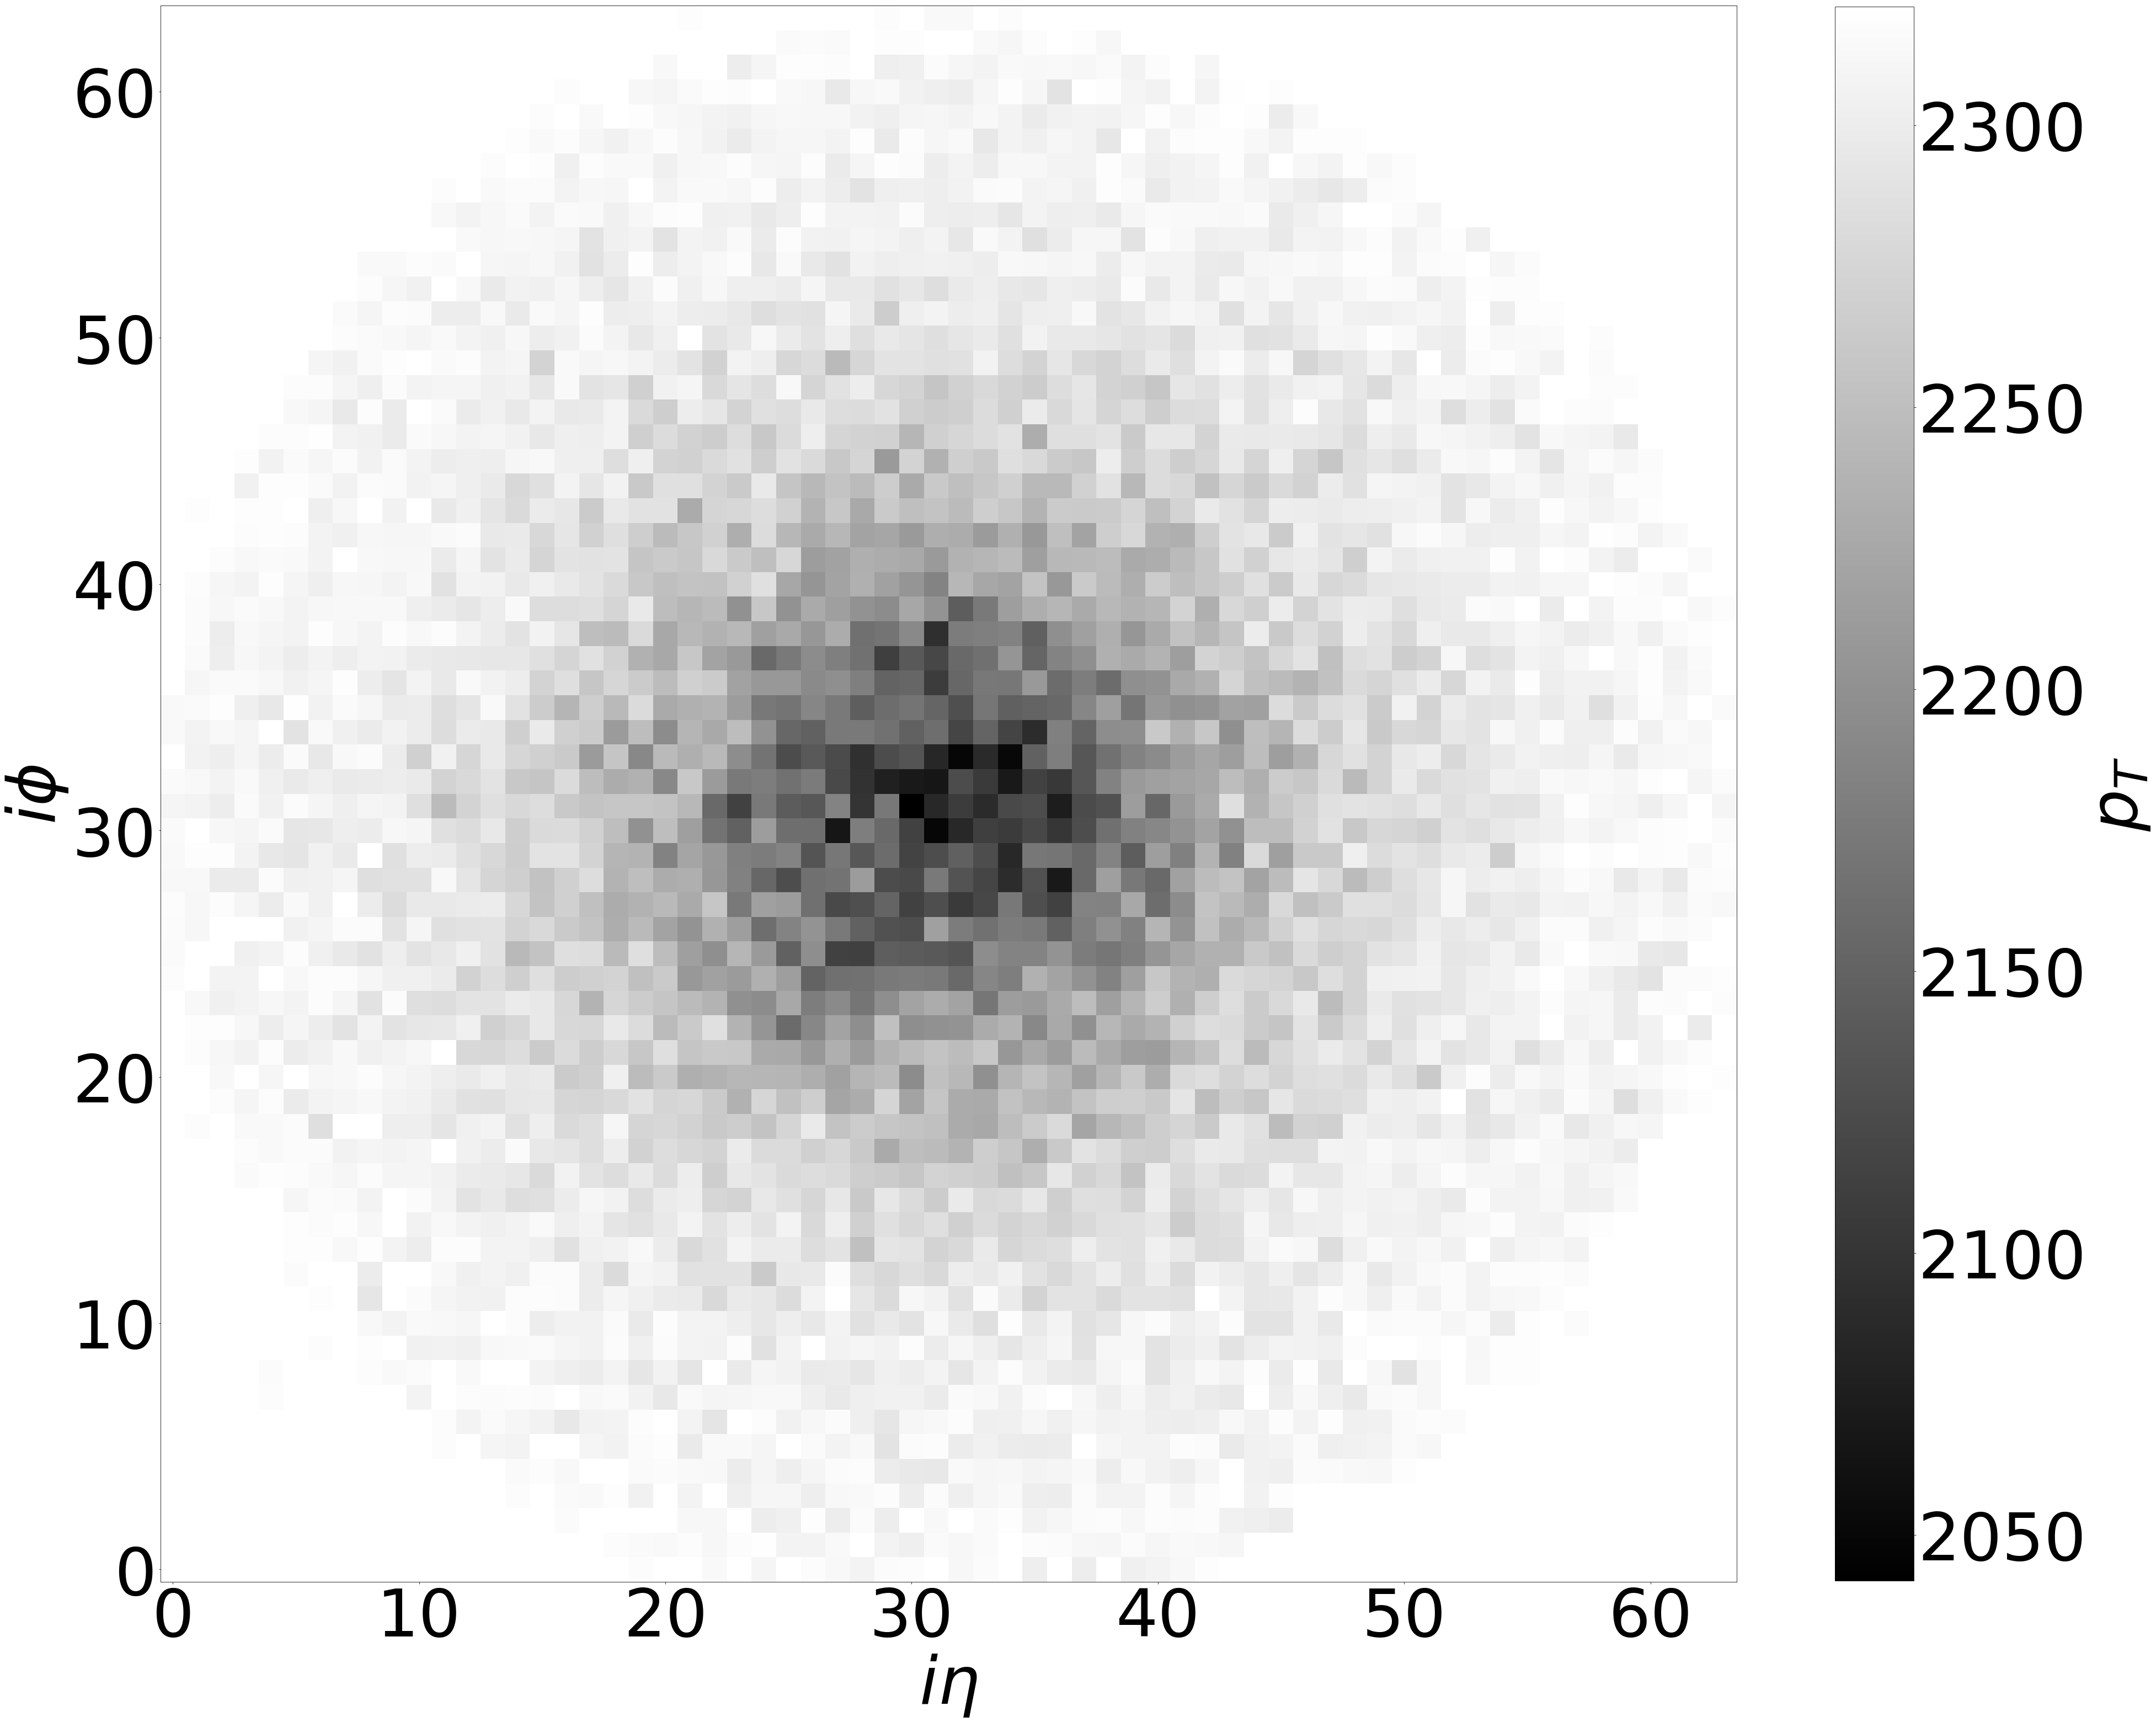

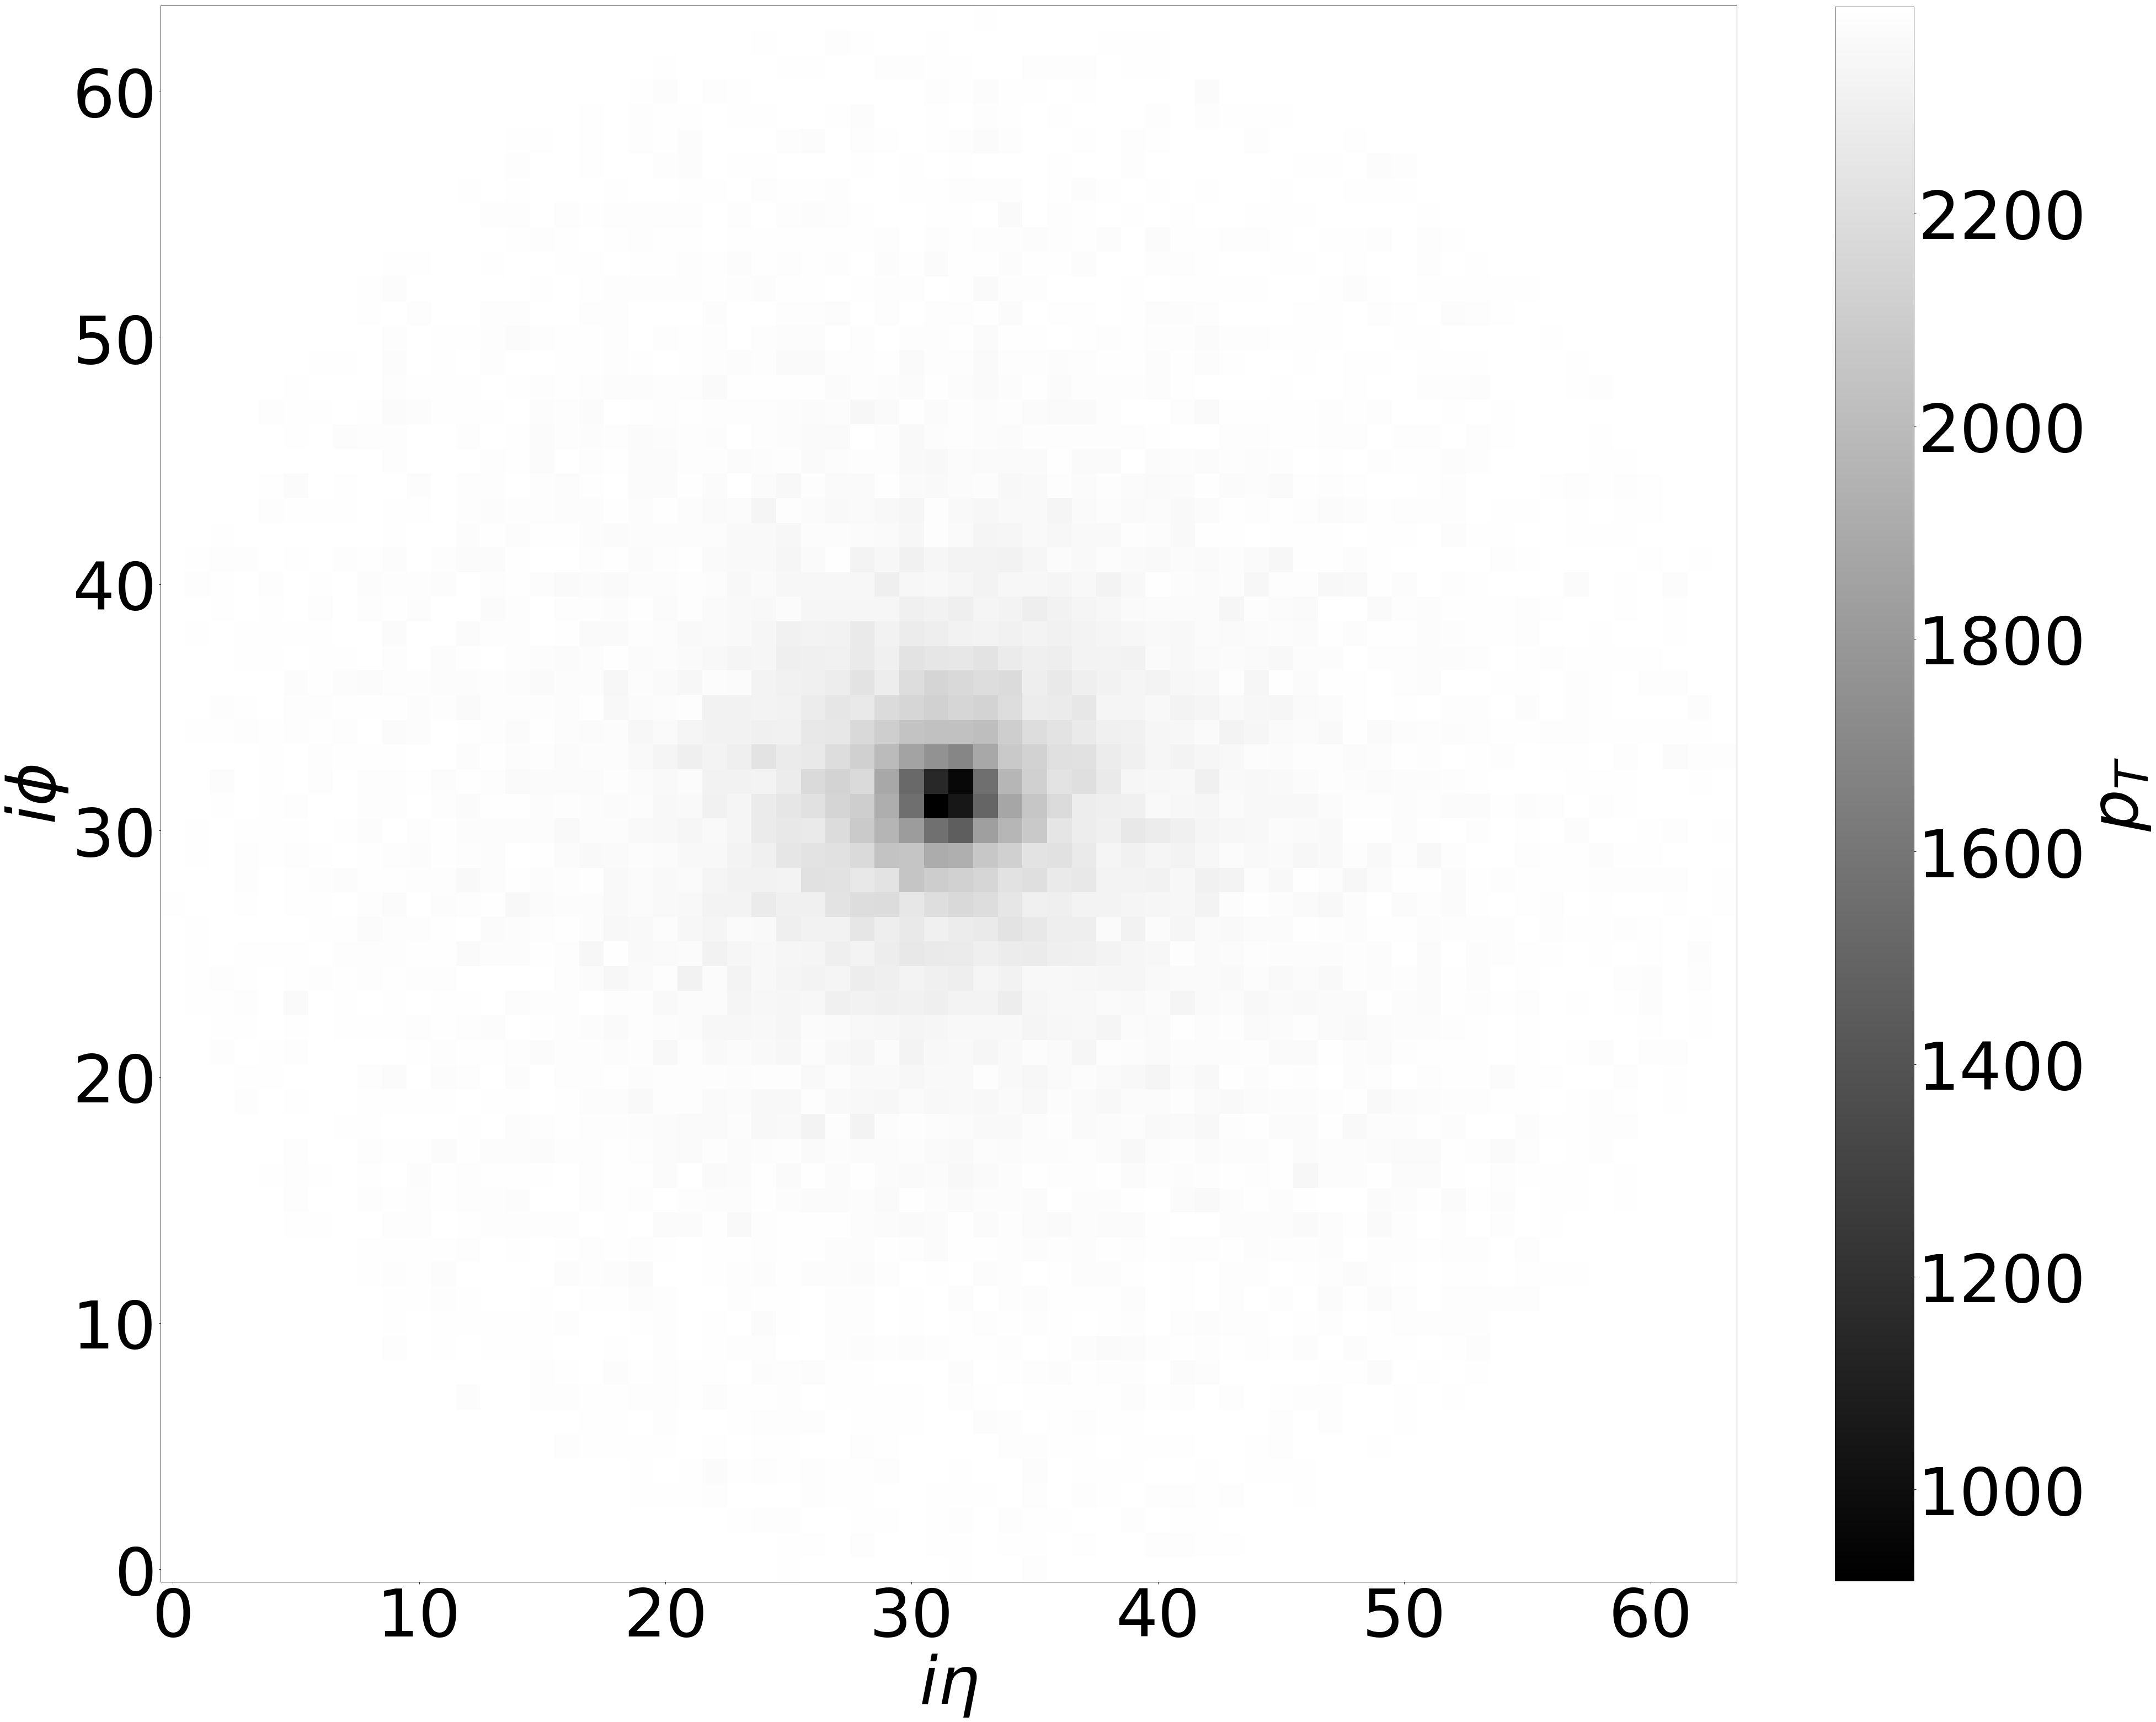

In [9]:
%matplotlib inline
#mpl.use('agg')

width = 64
height = 64
fontsize = 120

plt.figure(figsize=(width,height))
ax = plt.subplot() 
for label in (ax.get_xticklabels() + ax.get_yticklabels()): label.set_fontsize(fontsize)
plt.imshow(c, origin='lower', interpolation='nearest',label='top', cmap='gray')
cbar = plt.colorbar(shrink=0.82)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'$p_T$', fontsize=fontsize)
plt.xlabel(r'$i\eta$', fontsize=fontsize)
plt.ylabel(r'$i\phi$', fontsize=fontsize)
plt.savefig('top.pdf')
plt.imsave('top.png',c,cmap='gray')

plt.figure(figsize=(width,height))
ax = plt.subplot() 
for label in (ax.get_xticklabels() + ax.get_yticklabels()): label.set_fontsize(fontsize)
plt.imshow(d, origin='lower', interpolation='nearest',label='QCD', cmap='gray')
cbar = plt.colorbar(shrink=0.82)
cbar.ax.tick_params(labelsize=fontsize)
cbar.set_label(r'$p_T$', fontsize=fontsize)
plt.xlabel(r'$i\eta$', fontsize=fontsize)
plt.ylabel(r'$i\phi$', fontsize=fontsize) 
plt.savefig('QCD.pdf')
plt.imsave('QCD.png',d,cmap='gray')

0.0 227.52767553112565
-5.427315831409947 4.605170185988091


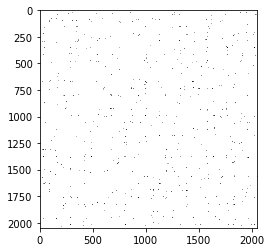

In [10]:
to_visualise = img_chunk[:,:,:,0]

to_visualise = np.log(to_visualise+0.01)
to_visualise = invert_grayscale(to_visualise, label_chunk[:,0])
sprite_image = create_sprite_image(to_visualise)

print(np.min(img_chunk[:,:,:,0]),np.max(img_chunk[:,:,:,0]))
print(np.min(to_visualise),np.max(to_visualise))

import matplotlib.pyplot as plt
%matplotlib inline
plt.imsave('./logjetimages.png',sprite_image,cmap='gray')
plt.imshow(sprite_image,cmap='gray')

In [11]:
print(sum(label_chunk[:,0])/label_chunk.shape[0])
with open('jetlabels.tsv','w') as f:
    f.write("Index\tLabel\n")
    for i in label_chunk[:,0]:
        if i: f.write("0\ttop\n")
        else: f.write("1\tQCD\n")

0.4921875


In [12]:
%%bash 
cat jetlabels.tsv

Index	Label
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
0	top
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QCD
1	QC

In [6]:
def construct_classifier_embed():
    from keras.layers import Dropout, Dense, Flatten, Input
    from keras.models import Model
    from keras import backend as K
    import tensorflow as tf
    K.set_session(tf.get_default_session())
    
    FC_SIZE = 1024
    NUM_CLASSES = 2

    in_layer = Input(shape=(1, 1, 2048,),name='input_1')
    x = Dropout(0.2, input_shape=(1, 1, 2048,),name='dropout_1')(in_layer)
    x = Dense(FC_SIZE, activation='relu', input_dim=(1, 1, 2048,),name='dense_1')(x)
    x = Flatten(name='flatten_1')(x)
    preds = Dense(NUM_CLASSES, activation='softmax', input_dim=FC_SIZE, name='classifier_output')(x)
    
    model = Model(inputs = in_layer, outputs = preds)
    embed_model = Model(inputs = in_layer, outputs = x)
    
    return model, embed_model

def construct_model_embed(quantized, saved_model_dir = None, starting_weights_directory = None, is_frozen=False):
    from azureml.contrib.brainwave.models import Resnet50, QuantizedResnet50
    import tensorflow as tf
    from keras import backend as K
    
    # Convert images to 3D tensors [width,height,channel]
    in_images, image_tensors = preprocess_images()

    # Construct featurizer using quantized or unquantized ResNet50 model
    
    if not quantized:
        featurizer = Resnet50(saved_model_dir, is_frozen=is_frozen, custom_weights_directory = starting_weights_directory)
    else:
        featurizer = QuantizedResnet50(saved_model_dir, is_frozen=is_frozen, custom_weights_directory = starting_weights_directory)
    
    features = featurizer.import_graph_def(input_tensor=image_tensors)
    
    # Construct classifier
    with tf.name_scope('classifier'):
        classifier, embed = construct_classifier_embed()
        preds = classifier(features)
        embed = embed(features)
    
    # Initialize weights
    sess = tf.get_default_session()
    tf.global_variables_initializer().run()
    
    if not is_frozen:
        featurizer.restore_weights(sess)
    
    if starting_weights_directory is not None:
        print("loading classifier weights from", starting_weights_directory+'/class_weights.h5')
        classifier.load_weights(starting_weights_directory+'/class_weights.h5')
        
    return in_images, image_tensors, features, preds, featurizer, classifier, embed

In [20]:
def test_model_embedding(preds, in_images, val_files, saver=None, checkpoint_path=None, embeddings=None, assignments=None): 
    """ training model w/embedding """ 
    import tensorflow as tf
    from keras import backend as K

    # Specify the loss function
    in_labels = tf.placeholder(tf.float32, shape=(None, 2))   
    
    sess = tf.get_default_session()
    # to re-initialize all variables 
    #sess.run(tf.group(tf.local_variables_initializer(),tf.global_variables_initializer()))
    # to re-initialize just local variables
    sess.run(tf.local_variables_initializer())

    img_chunk_embed, label_chunk_embed = image_with_label(val_files[0],0,1024)
    
    writer = tf.summary.FileWriter(checkpoint_path + '/logs', sess.graph)
    config = tf.contrib.tensorboard.plugins.projector.ProjectorConfig()
    for embedding in embeddings:
        embedding_config = config.embeddings.add()
        embedding_config.tensor_name = embedding.name
        embedding_config.sprite.image_path = '/home/jduarte/MachineLearningNotebooks/project-brainwave/logjetimages.png'
        embedding_config.metadata_path = '/home/jduarte/MachineLearningNotebooks/project-brainwave/jetlabels.tsv'
        # Specify the width and height of a single thumbnail.
        embedding_config.sprite.single_image_dim.extend([64, 64])
        tf.contrib.tensorboard.plugins.projector.visualize_embeddings(writer, config)

    
    sess.run(assignments, feed_dict={in_images: img_chunk_embed, 
                                    in_labels: label_chunk_embed,
                                    K.learning_phase(): 0})
    saver.save(sess, os.path.join(checkpoint_path + '/logs/', 'model.ckpt'), 0)

In [22]:
# Launch the session
tf.reset_default_graph()
sess = tf.Session(graph=tf.get_default_graph())

with sess.as_default():
    in_images, image_tensors, features, preds, featurizer, classifier, embed = construct_model_embed(quantized=False, saved_model_dir=saved_model_dir, starting_weights_directory=custom_weights_dir)
    embed_input = tf.reshape(in_images[:,:,:,0],[-1,64*64])
    n_images = 1024
    embeddings = []
    assignments = []
    embeddings.append(tf.Variable(tf.zeros([n_images, 1024]), name="feature_embedding"))
    embeddings.append(tf.Variable(tf.zeros([n_images, 64*64]), name="input_embedding"))
    assignments.append(embeddings[0].assign(embed))
    assignments.append(embeddings[1].assign(embed_input))
    saver = tf.train.Saver(max_to_keep = 100)
    test_model_embedding(preds, in_images, val_files, saver=saver, checkpoint_path=custom_weights_dir, embeddings=embeddings, assignments=assignments) 
    #loss, accuracy, auc, preds_test, test_labels = test_model(preds, in_images, test_files)

INFO:tensorflow:Restoring parameters from ../weights-floatingpoint/resnet50_bw
loading classifier weights from ../weights-floatingpoint/class_weights.h5
